# Illustrations for the Wavelet Model

In [64]:
# import relevant packages 
from src.data.preprocess_utils import bin_data
from scipy.signal import chirp, cwt, morlet
from scipy.fftpack import fft, fftfreq
from src.model.wavelet_model import * 
from matplotlib import pyplot as plt 
from scipy.signal import find_peaks
import seaborn as sns 
import numpy as np 
import pickle 
import pywt 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')



### Mother wavelet 

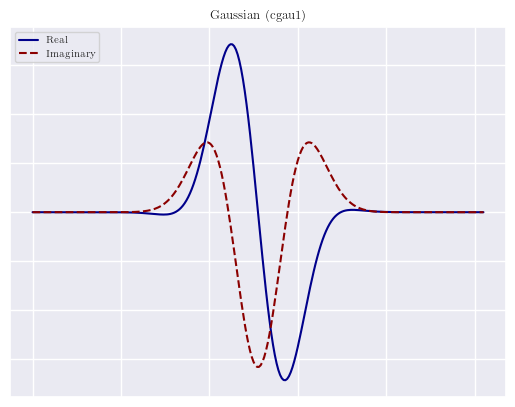

In [14]:
wavelet = pywt.ContinuousWavelet('cgau1')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Gaussian (cgau1)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "cgau1_wavelet", width = 2.5, height = 1.56)

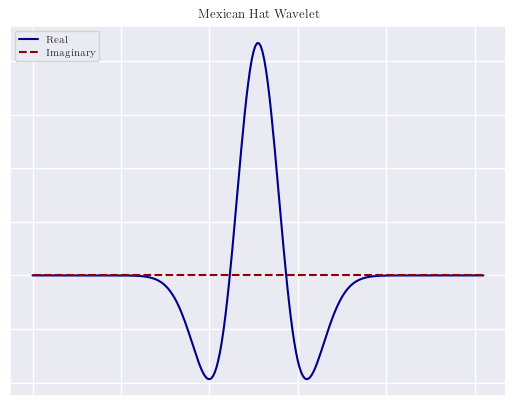

In [12]:
wavelet = pywt.ContinuousWavelet('mexh')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Mexican Hat Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mexican_hat", width = 2.5, height = 1.56)

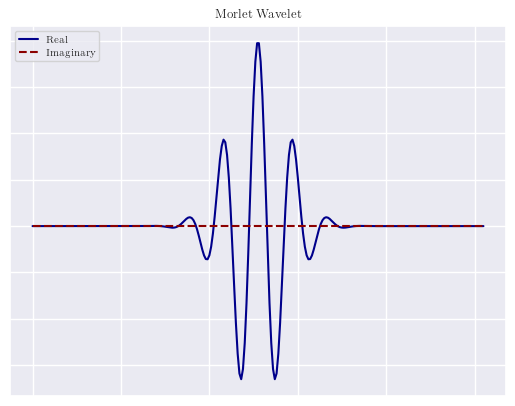

In [13]:
wavelet = pywt.ContinuousWavelet('morl')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Morlet Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mor", width = 2.5, height = 1.56)

### Wavelet Coefficients 

In [4]:
with open("simulated_data.pkl", 'rb') as f:
    file = pickle.load(f)
f.close()

channel = 2
bin_idx = 1
peaks, _ = find_peaks(file['filtered_signal'][:, channel], height = 30, distance = 2900)
bins = bin_data(file['filtered_signal'][:, channel], peaks).T 
true_bins = bin_data(file['true_signal'][:, channel], peaks).T

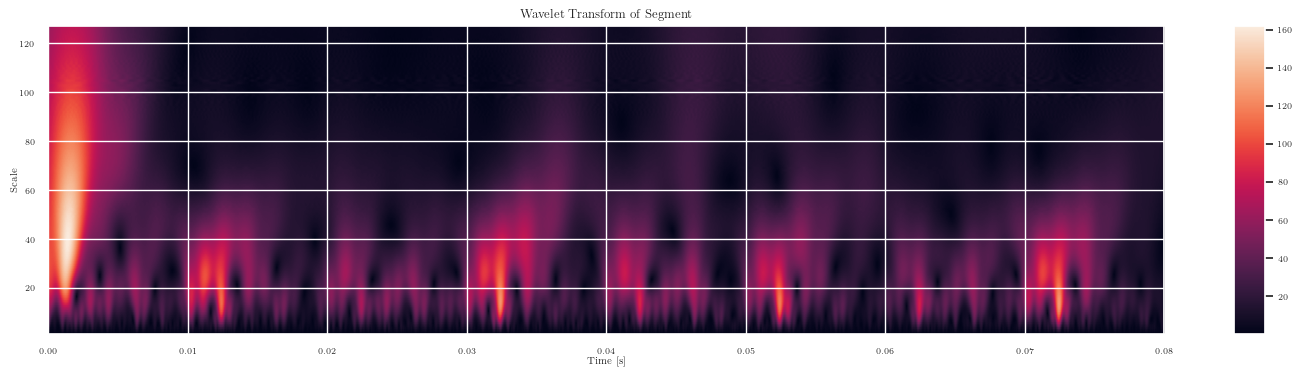

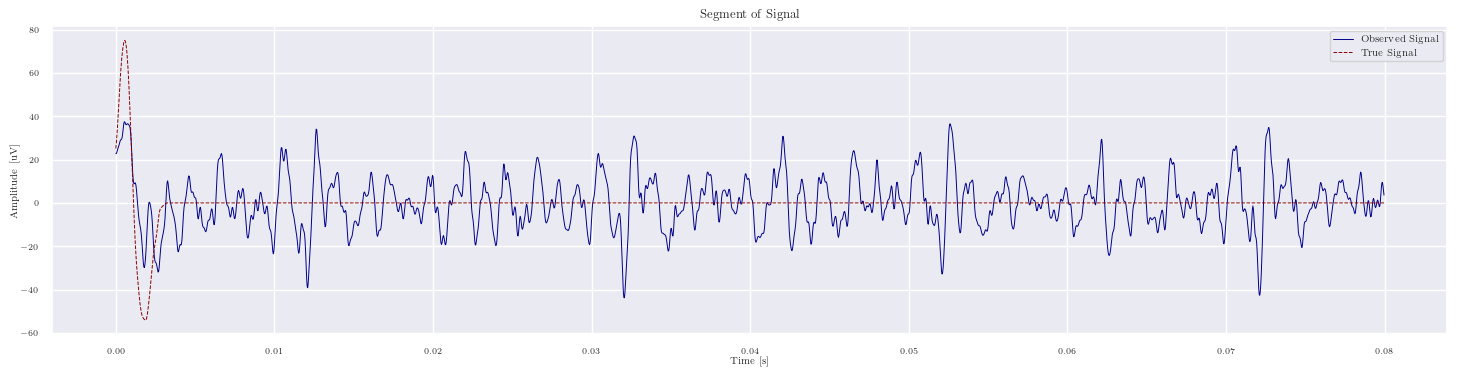

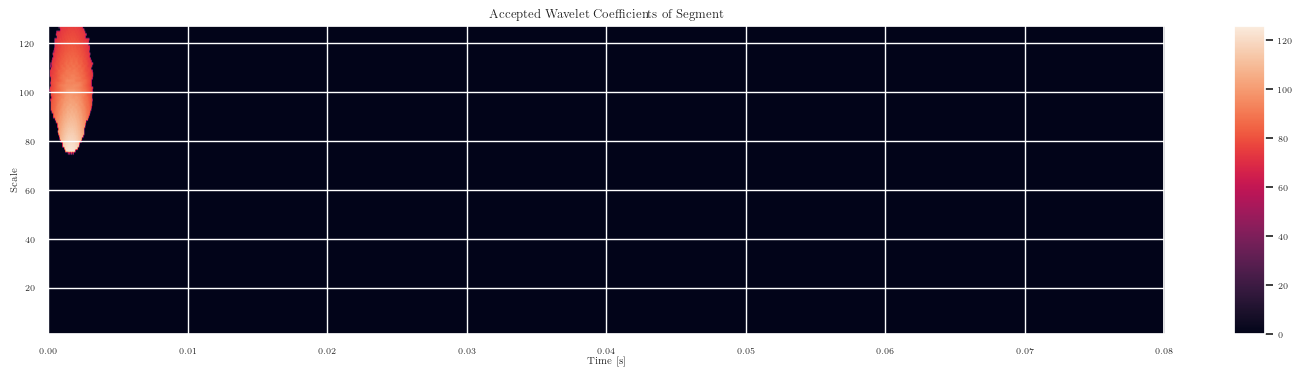

In [5]:
# apply wavelet transform
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.title("Wavelet Transform of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients", width = 6, height=1.5)

fig = plt.figure(figsize = (18, 4))
plt.plot(np.arange(2400) / 30000, bins[:, bin_idx], color = "darkblue", linewidth = 0.7)
plt.plot(np.arange(2400) / 30000, true_bins[:, bin_idx], '--', color = "darkred", linewidth = 0.7)
plt.title("Segment of Signal")
plt.ylabel("Amplitude [uV]")
plt.xlabel("Time [s]")
plt.legend(["Observed Signal", "True Signal"])
plt.show()

savefig(fig, "wavelet_time_segment", width = 6, height=1.5)

accepted_coefficients = get_accepted_coefficients(coefficients, scales)[1]

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(accepted_coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect = 10)
plt.title("Accepted Wavelet Coefficients of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients_accepted", width = 6, height=1.5)



### Illustration of Different Mother Wavelets 

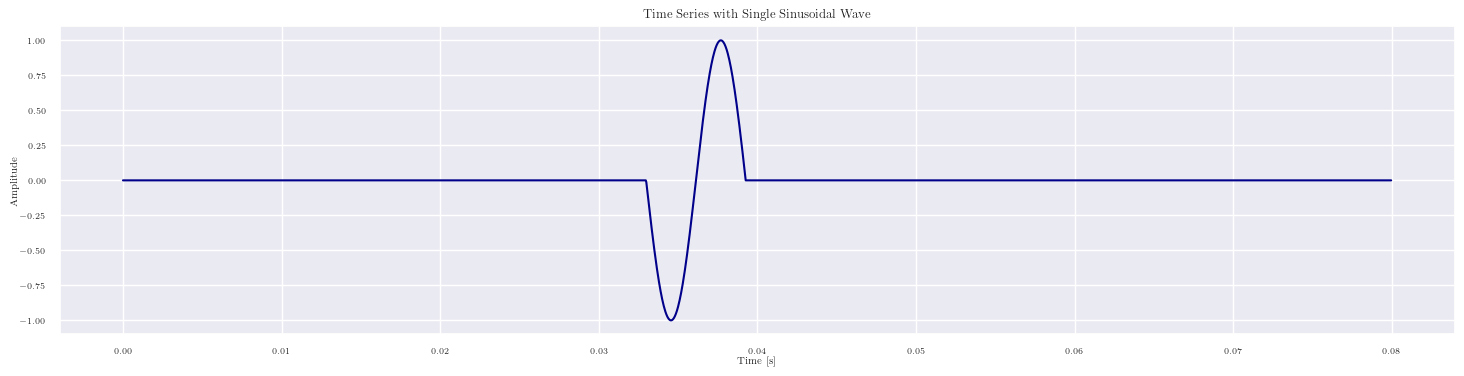

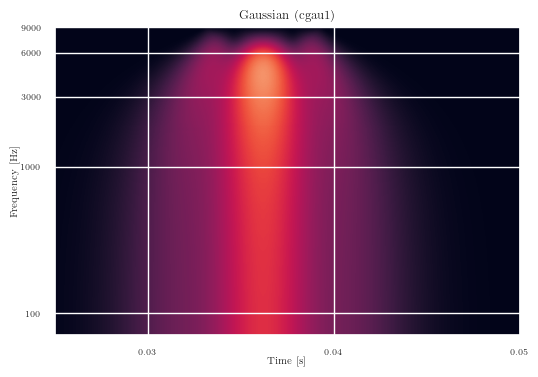

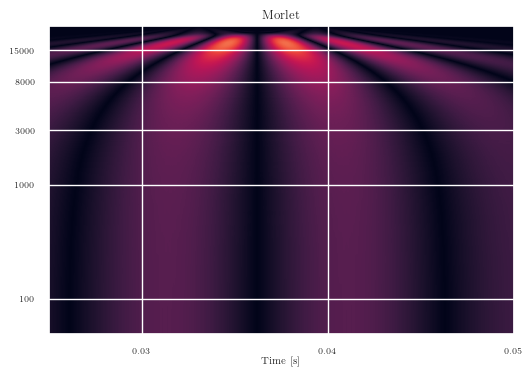

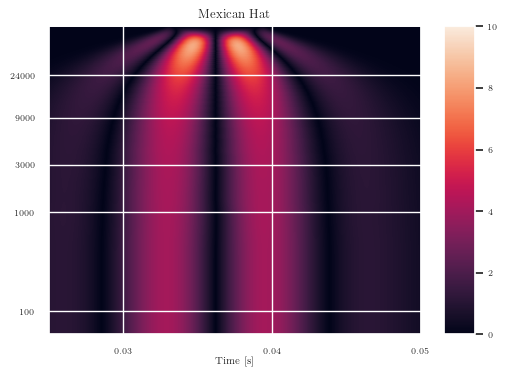

In [125]:
t = np.arange(2400) / 30000
# x = np.cos(1000 *  t)
x = np.zeros(2400)
# insert single sinusoidal wave
x[990:1178] = np.cos(1000 * t[990:1178])

coefs, frequencies = pywt.cwt(x, scales, wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.plot(t, x, color = "darkblue")
plt.title("Time Series with Single Sinusoidal Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

savefig(fig, "wavelet_single_sinus", width = 6.5, height=1.5)


fig = plt.figure(figsize = (6, 4))
plt.imshow(np.flipud(np.abs(coefs)), extent=[0, len(x) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower',  vmin = 0, vmax = 10)
# plt.colorbar(aspect = 10)
plt.yscale('log')  # Logarithmic scale for frequency
plt.yticks([100, 1000, 3000, 6000, 9000], ["100", "1000", "3000", "6000", "9000"])
plt.xticks([0.03, 0.04, 0.05], ["0.03", "0.04", "0.05"])
plt.title("Gaussian (cgau1)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.xlim([0.025, 0.05])
plt.show()

savefig(fig, "wavelet_single_sinus_gaus", width = 1.7, height=1.2)


coefs, frequencies = pywt.cwt(x, np.arange(1, 500), wavelet='morl', sampling_period=1/30000)


fig = plt.figure(figsize = (6, 4))
plt.imshow(np.flipud(np.abs(coefs)), extent=[0, len(x) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower', vmin = 0, vmax = 10)
# plt.colorbar(aspect = 10)
plt.yscale('log')  # Logarithmic scale for frequency
plt.yticks([100, 1000, 3000, 8000, 15000], ["100", "1000", "3000", "8000", "15000"])
plt.xticks([0.03, 0.04, 0.05], ["0.03", "0.04", "0.05"])
plt.title("Morlet")
# plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.xlim([0.025, 0.05])
plt.show()

savefig(fig, "wavelet_single_sinus_morl", width = 1.7, height=1.2)

coefs, frequencies = pywt.cwt(x, np.linspace(0.1, 128, num=140), wavelet='mexh', sampling_period=1/30000)


fig = plt.figure(figsize = (6, 4))
plt.imshow(np.flipud(np.abs(coefs)), extent=[0, len(x) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower',  vmin = 0, vmax = 10)
plt.colorbar(aspect = 10)
plt.yscale('log')  # Logarithmic scale for frequency
plt.yticks([100, 1000, 3000, 9000, 24000], ["100", "1000", "3000", "9000", "24000"])
plt.xticks([0.03, 0.04, 0.05], ["0.03", "0.04", "0.05"])
plt.title("Mexican Hat")
# plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.xlim([0.025, 0.05])
plt.show()

savefig(fig, "wavelet_single_sinus_mexh", width = 1.7, height=1.2)



### Time vs Frequency vs Wavelet Domain 

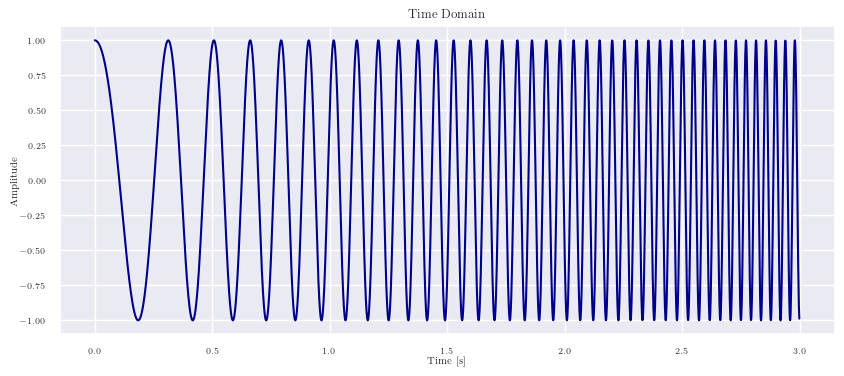

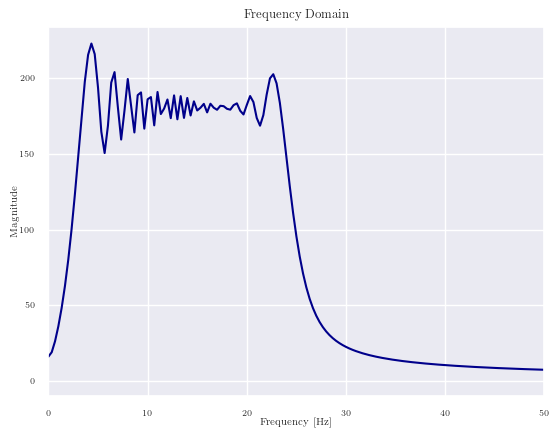

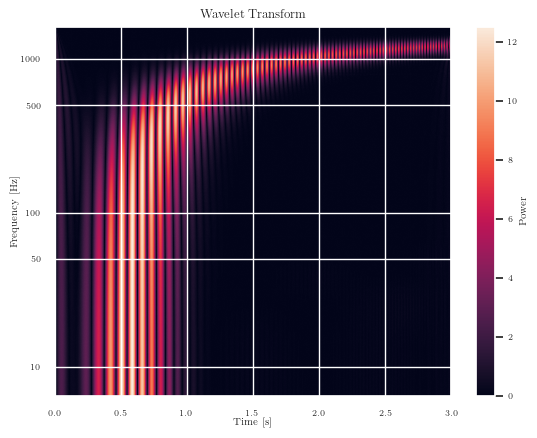

In [61]:
# Parameters
fs = 1000   # Sampling frequency (Hz)
T = 3       # Signal duration (seconds)
t = np.linspace(0, T, fs * T, endpoint=False)

# Generate a chirp signal (frequency increasing from 5 Hz to 50 Hz)
f_start, f_end = 2, 25 
signal = chirp(t, f0=f_start, f1=f_end, t1=T, method='linear')

# Compute Fourier Transform
N = len(t)
freqs = fftfreq(N, 1/fs)  # Frequency axis
fft_vals = np.abs(fft(signal))  # Magnitude of FFT

# Compute Scalogram using Continuous Wavelet Transform (CWT)
scales = np.r_[0.5, np.arange(1, 128)]
coefficients, frequencies = pywt.cwt(signal, scales = scales, sampling_period=1/fs, wavelet = "morl")


# Plot time series 
fig = plt.figure(figsize=(10, 4))
plt.plot(t, signal, color = "darkblue")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Time Domain")
plt.show()

# savefig(fig, "sinus_increasing_freq_time", width = 6.5, height=1.5)


# Plot the Fourier Transform
fig = plt.figure()
plt.plot(freqs[:N//2], fft_vals[:N//2], color = "darkblue")  # Plot only positive frequencies
plt.title("Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim([0, f_end * 2])
plt.show()

# savefig(fig, "sinus_increasing_freq_fourier", width = 3, height=1.5)

# plot wavelet space 
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.abs(coefficients), aspect='auto', extent=[0, T, frequencies[-1], frequencies[0]],
               interpolation='bicubic')
ax.set_yscale("log")
ax.set_yticks([10, 50, 100, 500, 1000])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")
ax.set_title("Wavelet Transform")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Power")
plt.show()

# savefig(fig, "sinus_increasing_freq_wavelet", width = 3, height=1.5)
